In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("employee-data/train.csv")

In [3]:
data_test = pd.read_csv("employee-data/test.csv")

In [4]:
data.shape

(22750, 9)

In [5]:
data.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [6]:
data_test.shape

(12250, 8)

In [7]:
data_test.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score'],
      dtype='object')

It appears that the test data does not contain a burn rate for each employee. In order to evaluate the performance of our model, we will work from only the labeled data (ie the training data).

Some general information about the each feature:

- Employee ID: The unique ID allocated for each employee (example: fffe390032003000)
- Date of Joining: The date-time when the employee has joined the organization (example: 2008-12-30)
- Gender: The gender of the employee (Male/Female)
- Company Type: The type of company where the employee is working (Service/Product)
- WFH Setup Available: Is the work from home facility available for the employee (Yes/No)
- Designation: The designation of the employee of work in the organization. In the range of [0.0, 5.0] bigger is higher designation.
- Resource Allocation: The amount of resource allocated to the employee to work, ie. number of working hours. In the range of [1.0, 10.0] (higher means more resource)
- Mental Fatigue Score: The level of fatigue mentally the employee is facing. In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.
- Burn Rate: The value we need to predict for each employee telling the rate of Burnout while working. In the range of [0.0, 1.0] where the higher the value is more is the burn out.

In [8]:
df = data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
Employee ID             22750 non-null object
Date of Joining         22750 non-null object
Gender                  22750 non-null object
Company Type            22750 non-null object
WFH Setup Available     22750 non-null object
Designation             22750 non-null float64
Resource Allocation     21369 non-null float64
Mental Fatigue Score    20633 non-null float64
Burn Rate               21626 non-null float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [10]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


We will first transform some of the data to make it more manageable to work with.

In [11]:
from datetime import datetime

In [12]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [13]:
today = datetime.today()

In [14]:
sec_yr = 365 * 24 * 60 * 60

In [15]:
df["Date of Joining"] = df["Date of Joining"].map(lambda date: datetime.strptime(date, "%Y-%m-%d"))

In [16]:
df["Years at Company"] = df["Date of Joining"].map(lambda date: round(((today - date).total_seconds()/sec_yr), 2))

In [17]:
df.drop(columns = ["Date of Joining", "Employee ID"], inplace=True)

In [26]:
cols = ['Years at Company','Gender', 'Company Type', 'WFH Setup Available', 'Designation',
       'Resource Allocation', 'Mental Fatigue Score', 'Burn Rate']
df = df[cols]

In [28]:
df.rename(columns={"Burn Rate": "Burnout Level"}, inplace=True)

In [32]:
df.duplicated().sum()

35

In [35]:
df.drop_duplicates(inplace=True)

In [36]:
df.isna().sum()

Years at Company           0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2108
Burnout Level           1122
dtype: int64

It appears that there are missing values for the predictors Resource Allocation and Mental Fatigue Score, and for the target class Burnout Level. We will drop the missing data from Burnout Level and impute values (using the median) for the other two predictors for our initial model.

In [42]:
df.dropna(subset = ["Burnout Level"], inplace=True)

In [46]:
med_ra = df["Resource Allocation"].median()
med_mf = df["Mental Fatigue Score"].median()

In [48]:
df["Resource Allocation"].fillna(value = med_ra, inplace=True)
df["Mental Fatigue Score"].fillna(value = med_mf, inplace=True)

In [49]:
df.isna().sum().sum()

0

In [50]:
df_pre = df

Since our model will apply classification algorithms, we will convert the burn rate columns into discrete classes of 1-5, with 1 being the lowest and 5 being the highest in terms of burnout.

In [51]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 5 if (rate > 0.8 and rate <= 1) else rate)

In [52]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 4 if (rate > 0.6 and rate <= 0.8) else rate)

In [53]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 3 if (rate > 0.4 and rate <= 0.6) else rate)

In [54]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 2 if (rate > 0.2 and rate <= 0.4) else rate)

In [55]:
df_pre["Burnout Level"] = df_pre["Burnout Level"].map(lambda rate: 1 if rate <= 0.2 else rate)

In [58]:
df_pre["Burnout Level"].value_counts(normalize=True)

3.0    0.369842
2.0    0.297180
4.0    0.183393
1.0    0.110777
5.0    0.038809
Name: Burnout Level, dtype: float64

In [59]:
df_pre.head()

,Years at Company,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burnout Level
0,12.24,Female,Service,No,2.0,3.0,3.8,1.0
1,12.07,Male,Service,Yes,1.0,2.0,5.0,2.0
2,12.79,Female,Product,Yes,2.0,4.0,5.8,3.0
3,12.14,Male,Service,Yes,1.0,1.0,2.6,1.0
4,12.42,Female,Service,No,3.0,7.0,6.9,3.0


Now that we have done some initial data cleaning, we can begin the process of EDA

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("notebook")
sns.set_palette("Spectral")
fs = (10, 10)
fss = (5, 5)
fs_long = (7, 15)
fs_wide = (15, 7)

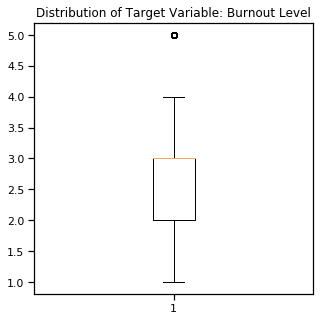

In [72]:
plt.figure(figsize=fss)
plt.boxplot(df_pre["Burnout Level"], showfliers=True)
plt.title("Distribution of Target Variable: Burnout Level")
plt.show()

<Figure size 360x360 with 0 Axes>

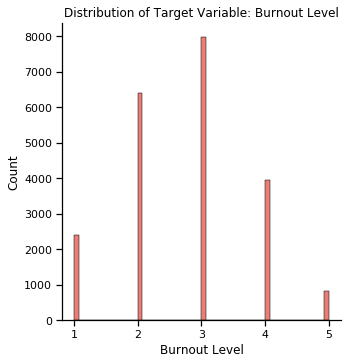

In [74]:
plt.figure(figsize=fss)
sns.displot(df_pre["Burnout Level"], kde=False)
plt.title("Distribution of Target Variable: Burnout Level")
plt.show()

Target variable is fairly normally distributed, with most instances falling into the burnout category of 3, and less in the two extremes of 1 and 5.

In [75]:
df_num = df_pre[["Years at Company", "Designation", "Resource Allocation", "Mental Fatigue Score"]]

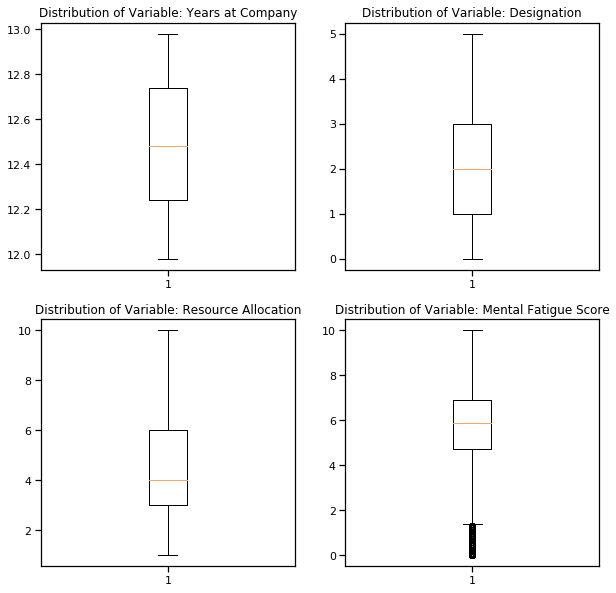

In [76]:
fig, axs = plt.subplots(2,2, figsize=(fs))
axs = axs.ravel()

for i in range(4):

    axs[i].boxplot(df_num.iloc[:, i], showfliers=True)
    axs[i].set_title("Distribution of Variable: " + str(df_num.iloc[:, i].name))

There appears to be some lower outliers in mental fatigue score. 

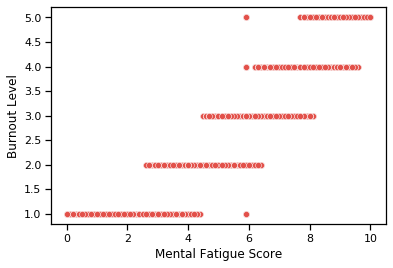

In [78]:
sns.scatterplot(x=df_pre["Mental Fatigue Score"], y=df_pre["Burnout Level"])
plt.show()

Mental fatigue score appears to be positively correlated with Burnout Level (ie as mental fatigue increases, burnout also tends to increase).

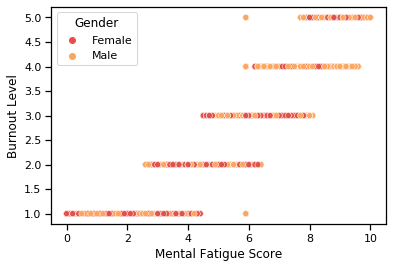

In [87]:
sns.scatterplot(x=df_pre["Mental Fatigue Score"], y=df_pre["Burnout Level"], hue=df_pre["Gender"])
plt.show()

In [89]:
df_pre["Gender"].value_counts(normalize=True)

Female    0.524707
Male      0.475293
Name: Gender, dtype: float64

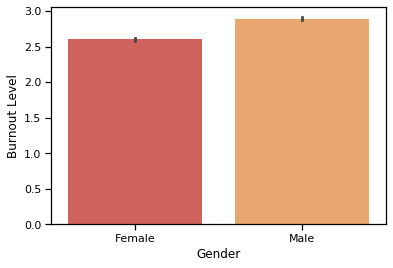

In [90]:
sns.barplot(x=df_pre["Gender"], y=df_pre["Burnout Level"])
plt.show()

It appears that men had slightly higher burnout levels on average.

In [96]:
df_pre.groupby(["Gender"]).median()

,Years at Company,Designation,Resource Allocation,Mental Fatigue Score,Burnout Level
Gender,,,,,
Female,12.48,2.0,4.0,5.8,3.0
Male,12.48,2.0,5.0,6.0,3.0


However, the medians both appear to converge at 3 for both males and females.

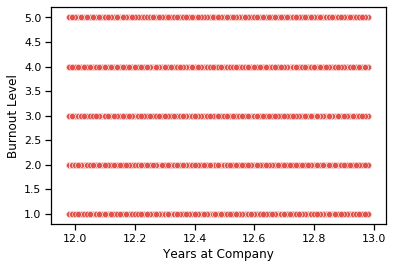

In [99]:
sns.scatterplot(x=df_pre["Years at Company"], y=df_pre["Burnout Level"])
plt.show()

There doesn't appear to be much of an influence from years at the company on burnout level, although this may be due to the fact that there is not much variation in terms of years worked.

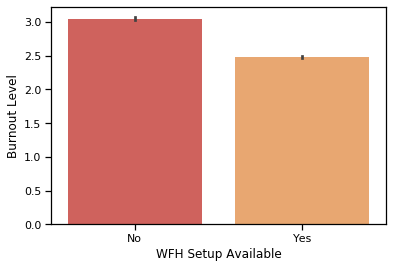

In [100]:
sns.barplot(x=df_pre["WFH Setup Available"], y=df_pre["Burnout Level"])
plt.show()

Not having a work from home setup appeared to correlate to higher burnout levels on average.

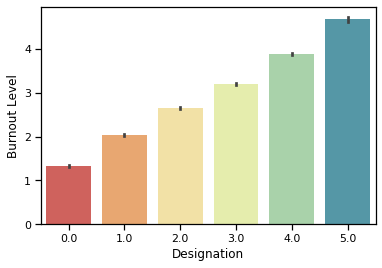

In [102]:
sns.barplot(x=df_pre["Designation"], y=df_pre["Burnout Level"])
plt.show()

Higher designations (Higher positions) appeared to also correlate positively to higher burnout levels.

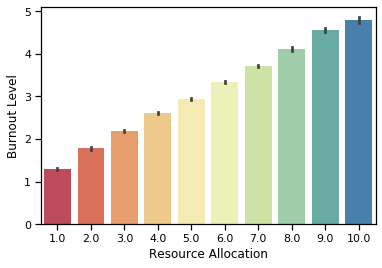

In [106]:
sns.barplot(x=df_pre["Resource Allocation"], y=df_pre["Burnout Level"], palette = "Spectral")
plt.show()

Higher resource allocation (ie more working hours) appears to also correlate positively with higher burnout. 

After doing some initial investigation, it appears employee burnout is greater in males, those who hold higher positions, and those who are allocated more working hours. It also seems that employees without a functioning WFH setup have a higher burnout level on average.

In [108]:
df_pre.groupby(["Burnout Level"]).median()

,Years at Company,Designation,Resource Allocation,Mental Fatigue Score
Burnout Level,,,,
1.0,12.47,1.0,2.0,2.5
2.0,12.48,2.0,3.0,4.7
3.0,12.48,2.0,5.0,6.2
4.0,12.48,3.0,6.0,7.7
5.0,12.49,4.0,8.0,9.1


In [114]:
high_burn = df_pre.loc[(df_pre["Burnout Level"] == 4) | (df_pre["Burnout Level"] == 5)]

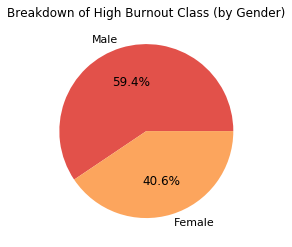

In [138]:
sizes = high_burn["Gender"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Gender)")
plt.show()

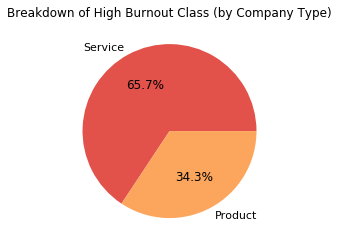

In [139]:
sizes = high_burn["Company Type"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Company Type)")
plt.show()

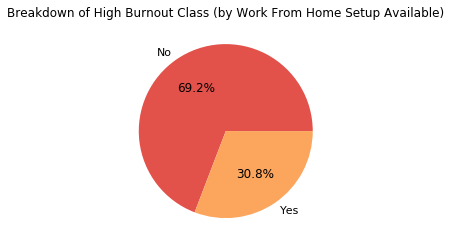

In [140]:
sizes = high_burn["WFH Setup Available"].value_counts(normalize=True)
labels = sizes.index
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Breakdown of High Burnout Class (by Work From Home Setup Available)")
plt.show()

Of the highest burnout classes (level 4 and 5), 60% were male, 66% worked in a service oriented company, and 70% did not have a WFH setup available.